# Import 

In [1]:

# load basic libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
# import matplotlib.mlab as mlab
# vizualisation libraries
import seaborn as sns
# csv
# import csv
# pandas
import pandas as pd
# add simple stat methods
from statistics import mean, stdev
from math import sqrt
from scipy.stats import norm
# fdr
import statsmodels.stats.multitest as multitest
# umap
import umap

from pathlib import Path

/home/tom/anaconda2/envs/hivscc/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Help functions

In [2]:
# box plot for 2 different values

def box_stripe_plot(feature_1,feature_2,label_1,label_2,title):
    
    # make a dataframe
    my_data = pd.DataFrame({label_1: pd.Series(feature_1), label_2: pd.Series(feature_2)})
    my_data.head()

    sns.boxplot(data = my_data.loc[:,:],palette="Set2",fliersize=0)
    sns.stripplot(data = my_data.loc[:,:],jitter=True,palette="Set2", split=True,linewidth=1,edgecolor='gray')
    plt.ylabel('Feature units')
    plt.title(title)


In [3]:

# box plot for 2 different values

def box_stripe_plot_2(f1,f2,f3,f4,l1,l2,l3,l4,title,feature_units):
    
    # make a dataframe
    my_data = pd.DataFrame({l1: pd.Series(f1),l2: pd.Series(f2),l3: pd.Series(f3),l4: pd.Series(f4)})
    my_data.head()
    
    # plot features out of dataframe
    
    fig, ax = plt.subplots()
    
    sns.boxplot(data = my_data.loc[:,:],palette="Set2",fliersize=0)
    sns.stripplot(data = my_data.loc[:,:],jitter=True,palette="Set2", split=True,linewidth=1,edgecolor='gray')
        
    # set axes to vertical
    #ax.set_xticklabels(labels_x,rotation='vertical')
    
    plt.ylabel(feature_units)
    plt.title(title)


In [4]:
# function to compute p-values

def compute_p_values(feature_names,cell_group,ephys_MET,norm_cell_ids,path_cell_ids,alpha_level=0.05,plot=True,save_plot=False):

    # this function takes the mouse and human data frames and computes the pairwise
    # difference between features using mann-whithney test with Bonferoni correction
    # the results are saved in P, D, feature name lists, cell_type

    # compare all features and compute p_values
    # 1 means the value has not been computed
    # number of features
    n_features=len(feature_names)
    # counter for significant features
    n_sign_features=0
    # lists for results
    p_values=np.ones(len(feature_names))
    d_values=np.ones(len(feature_names))
    
    # list for cohens_coefficients and key names
    cohens_d=[]

    # plot the box plots for pairwise feature comparisons

    for i in range(len(feature_names)):

        # compute corresponding features from dataframes                        
        feature_1=ephys_MET.loc[ephys_MET['specimen_id'].isin(norm_cell_ids)][feature_names[i]].values
        feature_2=ephys_MET.loc[ephys_MET['specimen_id'].isin(path_cell_ids)][feature_names[i]].values

        # remove the NaN's
        feature_1 = feature_1[~np.isnan(feature_1)]
        feature_2 = feature_2[~np.isnan(feature_2)]

        # convert arrays to lists
        feature_1=feature_1.tolist()
        feature_2=feature_2.tolist()

        if feature_1:
            if feature_2:
                # p-values is computed by mann whitheney test
                d,p=stats.mannwhitneyu(feature_1,feature_2)
                # record the p_values
                p_values[i]=p
                d_values[i]=d
                # norm / path
                labels=['Norm: ' + cell_group +' (N='+str(len(feature_1)) +')','Path: ' + cell_group + ' (N='+str(len(feature_2)) +')']
                # count the number of different features
                if p<=float(alpha_level/n_features):
                    n_sign_features=n_sign_features+1
                if plot==True:                    
                    if p<=float(alpha_level/n_features):
                        fig, ax = plt.subplots()
                        # compute the effect size
                        cohens_d.append(np.abs((mean(feature_1) - mean(feature_2)) / (sqrt((stdev(feature_1) ** 2 + stdev(feature_2) ** 2) / 2))))                        
                        if p<=float(alpha_level/n_features):
                            title = feature_names[i] +str(' (significant)') +str(' effect size ') +str(np.round(cohens_d[-1],2))
                        else:
                            title = feature_names[i] +str(' (non-significant)') +str(' effect size ') +str(np.round(cohens_d[-1],2))                        
                        box_stripe_plot(feature_1,feature_2,labels[0],labels[1],title)
                        # save figure part
                        if save_plot == True:                            
                            plt.savefig(str(str(feature_names[i])+'.pdf'), format='pdf', dpi=300)

    # compute fdr corrected p-values    
    p_values_bool,p_values_fdr=multitest.fdrcorrection(p_values,alpha=0.05)    
    print ('Bonferroni: ' + str(n_sign_features) + ' out of ' + str(n_features) + str(' features are different'))
    print ('FDR: ' + str(len(p_values_fdr[p_values_fdr <= 0.05])) + ' out of ' + str(n_features) + str(' features are different'))
    print()
    
    return p_values_fdr, d_values, feature_names, n_sign_features


In [5]:

def provide_cell_ids(path_info,my_data_MET_ephys,path_type,low_thr,high_thr):
    
    # healthy
    norm_donor_values=path_info.loc[path_info[path_type] <= low_thr ]['donor_id'].values
    # unhealthy
    path_donor_values=path_info.loc[path_info[path_type] > high_thr ]['donor_id'].values
    
    # EXCITATORY CELLS
    spiny_cells=my_data_MET_ephys
    # healthy spiny cells
    spiny_cells_norm=spiny_cells.loc[spiny_cells['donor'].isin(norm_donor_values)]
    # path spiny cells
    spiny_cells_path=spiny_cells.loc[spiny_cells['donor'].isin(path_donor_values)]
    
    # spiny cell ids
    spiny_norm_cell_ids=spiny_cells_norm['SpecimenID'].values
    spiny_path_cell_ids=spiny_cells_path['SpecimenID'].values

    return spiny_norm_cell_ids, spiny_path_cell_ids


# Import the pathology info

In [6]:

path_info=pd.read_csv(Path('../data/pathology_scoring.csv'))
path_info.head()

# Rename donor info
for i in range(len(path_info)):
    path_info['donor_id'].iloc[i]=path_info['donor_id'].iloc[i][:10]

# show the results
path_info.head()


/home/tom/anaconda2/envs/hivscc/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,donor_id,GFAP Cortex,GFAP ctx ABC,Iba1 Cortex,SMI32 Cortex,Ki67,NeuN Orientation Layering,Cellularity,Pvalb
0,H15.03.006,1.333333,NaN,0.666667,0.0,3.0,0.0,1.333333,1.33
1,H15.06.016,0.666667,NaN,0.000000,0.0,0.0,0.0,0.666667,3.00
2,H15.06.017,1.333333,NaN,0.333333,0.0,0.0,0.0,0.666667,1.00
3,H15.06.018,0.666667,NaN,0.333333,0.0,1.0,0.0,0.333333,2.00
4,H16.03.001,2.333333,NaN,1.333333,NaN,1.0,0.0,0.333333,NaN


# Import ephys and data labels

In [7]:
ephys_path = Path('../data/human_mouse_ephys_all_0127.csv')
mouse_cells_path = Path("../data/mouse_IVSCC_excitatory_L23_consolidated_0129.csv")
human_cells_path = Path("../data/human_IVSCC_excitatory_L23_consolidated_0131.csv")

In [8]:

# human and mouse ephys data
ephys_human = pd.read_csv(ephys_path)
# take only cells with all features computed
ephys_human=ephys_human.dropna(axis=0)

# human labels
data_human = pd.read_csv(human_cells_path)
# filter to take only 3 cell types
#cell_types=['Exc L2-3 LINC00507 FREM3','Exc L2 LAMP5 LTK','Exc L2-4 LINC00507 GLP2R']
#data_human=data_human.loc[data_human['SeuratMapping'].isin(cell_types)]


## Get feature names

In [9]:

feature_names=ephys_human.columns.values
# remove the cell id label
feature_names=feature_names[1:]

print ('These are features being used')
print (feature_names)


These are features being used
['adapt_mean' 'avg_rate_hero' 'downstroke_long_square'
 'fast_trough_v_long_square_rel' 'fi_fit_slope' 'first_isi_hero_inv'
 'input_resistance' 'latency_rheo' 'peak_v_long_square_rel' 'rheobase_i'
 'sag' 'tau' 'threshold_v_long_square' 'trough_v_long_square_rel'
 'upstroke_downstroke_ratio_long_square' 'upstroke_long_square'
 'v_baseline' 'width_long_square']


## Filter patch-seq dataset by specimen

In [10]:
# Restrict to temporal cortex only
my_data_MET = data_human[data_human.region=='temporal']

cell_ids=ephys_human['specimen_id'].values
#cell_ids=ephys_MET['specimen_id'].values
cell_ids=cell_ids.astype(np.str)

# my_data_MET_ephys = my_data_MET.loc[my_data_MET['spec_id_label'].isin(cell_ids)]
my_data_MET_ephys = my_data_MET.loc[my_data_MET['SpecimenID'].isin(cell_ids)]
my_data_MET_ephys.head()


,SpecimenID,sample_id,batch,donor,collaborator,gender,medical_conditions,region,hemisphere,age,...,isTCX,postPatch,rna_amplification_call,marker_sum_norm,quality_score,contam_sum,contaminationType,SeuratMapping,SeuratMappingScore,Is_deep_FREM3
5,541557114,P1S4_160826_912_A01,285-813,H16.03.007,Lein,female,Epilepsy,temporal,left,28.0,...,True,nucleus_present,Pass,0.468745,0.280213,0.961766,Microglia,Exc L2 LAMP5 LTK,0.626584,False
7,569835804,P1S4_170214_004_A01,BT024,H17.03.002,Lein,male,Epilepsy,temporal,right,61.0,...,True,nucleus_present,Pass,0.558213,0.300927,0.620767,Microglia,Exc L2 LAMP5 LTK,0.833210,False
9,571511167,P1S4_170228_008_A01,BT024,H17.06.005,Lein,male,Epilepsy,temporal,left,38.0,...,True,nucleus_present,Pass,0.639456,0.451395,0.343503,Microglia,Exc L2-3 LINC00507 FREM3,0.783508,False
10,571640763,P1S4_170301_003_A01,BT024,H17.06.006,Lein,male,Epilepsy,temporal,left,NaN,...,True,nucleus_absent,Pass,0.630096,0.411235,0.534354,Endothelial,Exc L2 LAMP5 LTK,0.928690,False
11,571732727,P1S4_170301_011_A01,BT024,H17.06.006,Lein,male,Epilepsy,temporal,left,NaN,...,True,nucleus_present,Pass,0.810625,0.478260,1.040079,Endothelial,Exc L2-3 LINC00507 FREM3,0.906805,True


## Prepare the data

In [11]:

# feature list
feature_list = ephys_human.keys().values
feature_list=feature_list[1:]

# cell IDs
human_ids = data_human['SpecimenID'].values

# form the datasets and sort them
ephys_human = ephys_human.loc[ephys_human['specimen_id'].isin(human_ids)]
ephys_human = ephys_human.sort_values(by=['specimen_id'])

# get the values
ephys_human_array = ephys_human.values
ephys_human_array = ephys_human_array[:,1:]

# get back the IDs
human_ids = ephys_human['specimen_id'].values

# get the labels and sort them
data_human=data_human.loc[data_human['SpecimenID'].isin(human_ids)]
data_human=data_human.sort_values(by='SpecimenID')
human_labels = data_human.loc[data_human['SpecimenID'].isin(human_ids)]['SeuratMapping'].values
path_labels=data_human.loc[data_human['SpecimenID'].isin(human_ids)]['medical_conditions'].values

# get the path and sort them
# data_path=data_path.loc[data_path['SpecimenID'].isin(human_ids)]
# data_path=data_path.sort_values(by='SpecimenID')
# path_labels=data_path.loc[data_path['SpecimenID'].isin(human_ids)]['medical_conditions_TX'].values


## Plot pathology score distribution

In [12]:

# Save the biomarker values
GFAP_cortex=path_info['GFAP Cortex'].values
Iba1_cortex=path_info['Iba1 Cortex'].values
SMI32_cortex=path_info['SMI32 Cortex'].values
Ki67=path_info['Ki67'].values
Neun_layer_orientation=path_info['NeuN Orientation Layering'].values
Cellularity=path_info['Cellularity'].values


### Average pathology score

Text(0.5, 15.0, 'Pathology score')

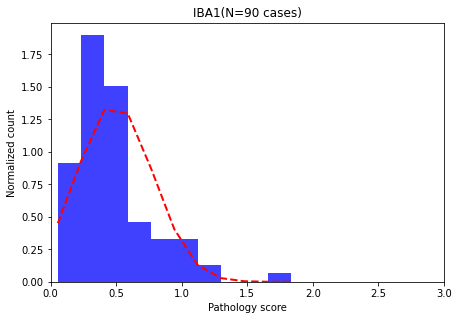

In [13]:
from scipy.stats import norm
# plot parameters
fig, axs = plt.subplots(1, 1)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

# sum the values
average_scores = path_info['GFAP Cortex']+path_info['Iba1 Cortex']+path_info['Ki67']+path_info['SMI32 Cortex']+path_info['NeuN Orientation Layering']+path_info['Cellularity']
# sum the scores
average_scores = average_scores / 6

# plot the average scores distribution
data=average_scores.values
# remove NaNs
data = data[~np.isnan(data)]
(mu, sigma) = norm.fit(data)
n, bins, patches = axs.hist(data, 10, density=True, facecolor='blue', alpha=0.75)
y = norm.pdf( bins, mu, sigma)
axs.plot(bins, y, 'r--', linewidth=2)
axs.set_title('IBA1(N=' + str(len(Iba1_cortex[~np.isnan(Iba1_cortex)])) +' cases)' )
axs.set_ylabel('Normalized count')
axs.set_xlim(0, 3)
axs.set_xlabel('Pathology score')

# save figure
#plt.savefig('averaged_score.pdf',format='pdf')


### Find the patients with the max/min degree of pathology

In [14]:

average_scores = path_info['GFAP Cortex']+path_info['Iba1 Cortex']+path_info['Ki67']+path_info['SMI32 Cortex']+path_info['NeuN Orientation Layering']+path_info['Cellularity']
# sum the scores
average_scores = average_scores / 6

max_val=np.nanmax(average_scores.values)
max_idx=np.argwhere(average_scores.values == max_val)[0][0]

min_val=np.nanmin(average_scores.values)
min_idx=np.argwhere(average_scores.values == min_val)[0][0]

print('Max path score')
donor_max = path_info.iloc[max_idx]['donor_id']
print(str(donor_max) +' ' + str(average_scores[max_idx]))
print()
print('Min path score')
donor_min = path_info.iloc[min_idx]['donor_id']
print(str(donor_min) +' ' + str(average_scores[min_idx]))


Max path score
H18.03.002 1.8333333333333324

Min path score
H18.03.317 0.055555555555555504


### Plot the scores distributions

(0.0, 3.0)

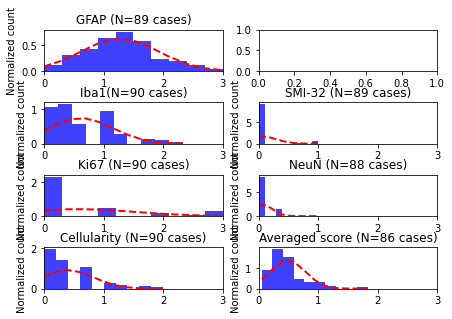

In [15]:
# list of all path scores
path_scores=[]

# plot parameters
fig, axs = plt.subplots(4, 2)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

# estimate the density
data=GFAP_cortex[~np.isnan(GFAP_cortex)]
(mu, sigma) = norm.fit(data)
n, bins, patches = axs[0,0].hist(data, 10, density=True, facecolor='blue', alpha=0.75)
y = norm.pdf( bins, mu, sigma)
axs[0,0].plot(bins, y, 'r--', linewidth=2)
#axs[0,0].hist(GFAP_cortex[~np.isnan(GFAP_cortex)],bins=10)
axs[0,0].set_title('GFAP (N=' + str(len(GFAP_cortex[~np.isnan(GFAP_cortex)])) +' cases)' )
axs[0,0].set_ylabel('Normalized count')
axs[0,0].set_xlim(0, 3)
path_scores.append(GFAP_cortex)

data=Iba1_cortex[~np.isnan(Iba1_cortex)]
(mu, sigma) = norm.fit(data)
n, bins, patches = axs[1,0].hist(data, 10, density=True, facecolor='blue', alpha=0.75)
y = norm.pdf( bins, mu, sigma)
axs[1,0].plot(bins, y, 'r--', linewidth=2)
axs[1,0].set_title('Iba1(N=' + str(len(Iba1_cortex[~np.isnan(Iba1_cortex)])) +' cases)' )
axs[1,0].set_ylabel('Normalized count')
axs[1,0].set_xlim(0, 3)
path_scores.append(Iba1_cortex)


data=SMI32_cortex[~np.isnan(SMI32_cortex)]
(mu, sigma) = norm.fit(data)
n, bins, patches = axs[1,1].hist(data, 10, density=True, facecolor='blue', alpha=0.75)
y = norm.pdf( bins, mu, sigma)
axs[1,1].plot(bins, y, 'r--', linewidth=2)
axs[1,1].set_title('SMI-32 (N=' + str(len(SMI32_cortex[~np.isnan(SMI32_cortex)])) +' cases)' )
axs[1,1].set_ylabel('Normalized count')
axs[1,1].set_xlim(0, 3)
path_scores.append(SMI32_cortex)


data=Ki67[~np.isnan(Ki67)]
(mu, sigma) = norm.fit(data)
n, bins, patches = axs[2,0].hist(data, 10, density=True, facecolor='blue', alpha=0.75)
y = norm.pdf( bins, mu, sigma)
axs[2,0].plot(bins, y, 'r--', linewidth=2)
#axs[2,0].hist(Ki67[~np.isnan(Ki67)],bins=10)
axs[2,0].set_title('Ki67 (N=' + str(len(Ki67[~np.isnan(Ki67)])) +' cases)' )
axs[2,0].set_ylabel('Normalized count')
axs[2,0].set_xlim(0, 3)
path_scores.append(Ki67)


data=Neun_layer_orientation[~np.isnan(Neun_layer_orientation)]
(mu, sigma) = norm.fit(data)
n, bins, patches = axs[2,1].hist(data, 10, density=True, facecolor='blue', alpha=0.75)
y = norm.pdf( bins, mu, sigma)
axs[2,1].plot(bins, y, 'r--', linewidth=2)
#axs[2,1].hist(Neun_layer_orientation[~np.isnan(Neun_layer_orientation)],bins=10)
axs[2,1].set_title('NeuN (N=' + str(len(Neun_layer_orientation[~np.isnan(Neun_layer_orientation)])) +' cases)' )
axs[2,1].set_ylabel('Normalized count')
axs[2,1].set_xlim(0, 3)
path_scores.append(Neun_layer_orientation)


data=Cellularity[~np.isnan(Cellularity)]
(mu, sigma) = norm.fit(data)
n, bins, patches = axs[3,0].hist(data, 10, density=True, facecolor='blue', alpha=0.75)
y = norm.pdf( bins, mu, sigma)
axs[3,0].plot(bins, y, 'r--', linewidth=2)
#axs[3,0].hist(Cellularity[~np.isnan(Cellularity)],bins=10)
axs[3,0].set_title('Cellularity (N=' + str(len(Cellularity[~np.isnan(Cellularity)])) +' cases)' )
axs[3,0].set_ylabel('Normalized count')
axs[3,0].set_xlim(0, 3)
path_scores.append(Cellularity)


data=average_scores.values
# remove NaNs
data = data[~np.isnan(data)]
(mu, sigma) = norm.fit(data)
n, bins, patches = axs[3,1].hist(data, 10, density=True, facecolor='blue', alpha=0.75)
y = norm.pdf( bins, mu, sigma)
axs[3,1].plot(bins, y, 'r--', linewidth=2)
axs[3,1].set_title('Averaged score (N=' + str(len(data)) +' cases)' )
axs[3,1].set_ylabel('Normalized count')
axs[3,1].set_xlim(0, 3)


#plt.savefig('path_grades.pdf', format='pdf')


# UMAP: pathological and normal cells

/home/tom/anaconda2/envs/hivscc/lib/python3.7/site-packages/umap/umap_.py:328: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../anaconda2/envs/hivscc/lib/python3.7/site-packages/umap/umap_.py", line 446:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/home/tom/anaconda2/envs/hivscc/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../anaconda2/envs/hivscc/lib/python3.7/site-packages/umap/umap_.py", line 329:
@numba.jit()
def fuzzy_simplicial_set(
^

  state.func_ir.loc))
/home/tom/anaconda2/envs/hivscc/lib/python3.7/site-packages/num

This is the UMAP shape


Text(0, 0.5, 'UMAP2')

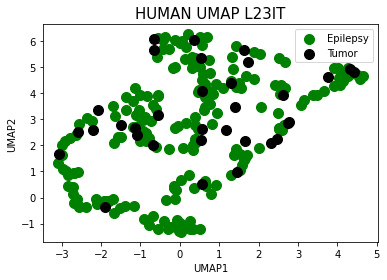

In [16]:

# fix the random seed
np.random.seed=42

X = ephys_human_array

# create the embedding
reducer = umap.UMAP()
# create the embedding shape
embedding = reducer.fit_transform(X)
print('This is the UMAP shape')
embedding.shape

# plot the results
fig, ax = plt.subplots()

idx=np.argwhere(path_labels=='Epilepsy')
plt.scatter(embedding[idx, 0], embedding[idx, 1], c='green', s=[100])
idx=np.argwhere(path_labels=='Tumor')
plt.scatter(embedding[idx, 0], embedding[idx, 1], c='black', s = [100])


plt.legend(['Epilepsy','Tumor'])
plt.title('HUMAN UMAP L23IT', fontsize=15)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

#plt.savefig('L23_path_ephys_UMAP.pdf')


# UMAP with different cell types

Text(0, 0.5, 'UMAP2')

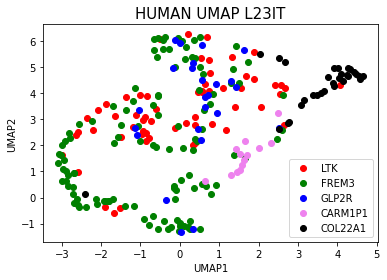

In [17]:
# plot the results
fig, ax = plt.subplots()

idx=np.argwhere(human_labels=='Exc L2 LAMP5 LTK')
plt.scatter(embedding[idx, 0], embedding[idx, 1], c='red')
idx=np.argwhere(human_labels=='Exc L2-3 LINC00507 FREM3')
plt.scatter(embedding[idx, 0], embedding[idx, 1], c='green')
idx=np.argwhere(human_labels=='Exc L2-4 LINC00507 GLP2R')
plt.scatter(embedding[idx, 0], embedding[idx, 1], c='blue')
idx=np.argwhere(human_labels=='Exc L3-4 RORB CARM1P1')
plt.scatter(embedding[idx, 0], embedding[idx, 1], c='violet')
idx=np.argwhere(human_labels=='Exc L3-5 RORB COL22A1')
plt.scatter(embedding[idx, 0], embedding[idx, 1], c='black')


plt.legend(['LTK','FREM3','GLP2R','CARM1P1','COL22A1'])
plt.title('HUMAN UMAP L23IT', fontsize=15)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')


# Compute all biomarkers p-values

GFAP
Bonferroni: 0 out of 18 features are different
FDR: 0 out of 18 features are different

Cellularity
Bonferroni: 0 out of 18 features are different
FDR: 0 out of 18 features are different

Iba1


/home/tom/anaconda2/envs/hivscc/lib/python3.7/site-packages/seaborn/categorical.py:2775: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/home/tom/anaconda2/envs/hivscc/lib/python3.7/site-packages/seaborn/categorical.py:2775: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


Bonferroni: 2 out of 18 features are different
FDR: 2 out of 18 features are different

Ki67
Bonferroni: 0 out of 18 features are different
FDR: 0 out of 18 features are different



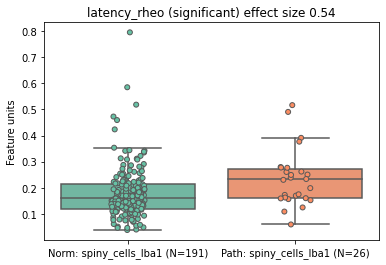

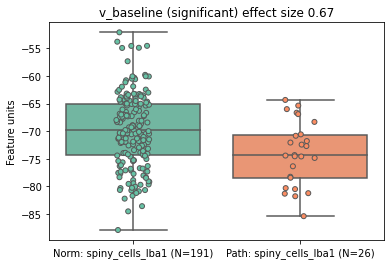

In [18]:

# store all p-values
all_p_val=np.zeros((18,4))

# set up all p-values vector
all_p_val=all_p_val=np.zeros((len(feature_names),4))

### GFAP
# all spiny and not spiny cells
spiny_norm_cell_ids, spiny_path_cell_ids = provide_cell_ids(path_info,my_data_MET_ephys,'GFAP Cortex',1,1)
# initial p_mean values
p_mean=np.zeros(len(feature_names))
#number of cells permutations
N=1
# compute the mean of p-values
for j in range(N):
    # sample size, min between two arrays
    n_sample = np.min([len(spiny_norm_cell_ids),len(spiny_path_cell_ids)])
    # number of cells in norm and path
    n_norm = len(spiny_norm_cell_ids)
    n_path = len(spiny_path_cell_ids)
    # indexes of norm and path elements
    idx_norm=np.random.choice(range(n_norm),n_sample,replace = False)
    idx_path=np.random.choice(range(n_path),n_sample,replace = False)
    print('GFAP')
    # compute p-values using one statistic
    p,d,features,n_features = compute_p_values(feature_names,'spiny_cells_GFAP',ephys_human,spiny_norm_cell_ids,spiny_path_cell_ids,alpha_level=0.05,plot=True,save_plot=False)
    # sum the p-values vector
    p_mean = p_mean + p
# save the average p-values
all_p_val[:,0]=-np.log10(p_mean/N)


### Cellularity
# all spiny and not spiny cells
spiny_norm_cell_ids, spiny_path_cell_ids = provide_cell_ids(path_info,my_data_MET_ephys,'Cellularity',1,1)
# initial p_mean values
p_mean=np.zeros(len(feature_names))
#number of cells permutations
#N=100
# compute the mean of p-values
for j in range(N):
    # sample size, min between two arrays
    n_sample = np.min([len(spiny_norm_cell_ids),len(spiny_path_cell_ids)])
    # number of cells in norm and path
    n_norm = len(spiny_norm_cell_ids)
    n_path = len(spiny_path_cell_ids)
    # indexes of norm and path elements
    idx_norm=np.random.choice(range(n_norm),n_sample,replace = False)
    idx_path=np.random.choice(range(n_path),n_sample,replace = False)
    print('Cellularity')
    p,d,features,n_features = compute_p_values(feature_names,'spiny_cells_Cellularity',ephys_human,spiny_norm_cell_ids,spiny_path_cell_ids,alpha_level=0.05,plot=True,save_plot=False)
    # sum the p-values vector
    p_mean = p_mean + p
# save the average p-values
all_p_val[:,1]=-np.log10(p_mean/N)


### Iba1
# all spiny and not spiny cells
spiny_norm_cell_ids, spiny_path_cell_ids = provide_cell_ids(path_info,my_data_MET_ephys,'Iba1 Cortex',1,1)
# initial p_mean values
p_mean=np.zeros(len(feature_names))
#number of cells permutations
#N=100
# compute the mean of p-values
for j in range(N):
    # sample size, min between two arrays
    n_sample = np.min([len(spiny_norm_cell_ids),len(spiny_path_cell_ids)])
    # number of cells in norm and path
    n_norm = len(spiny_norm_cell_ids)
    n_path = len(spiny_path_cell_ids)
    # indexes of norm and path elements
    idx_norm=np.random.choice(range(n_norm),n_sample,replace = False)
    idx_path=np.random.choice(range(n_path),n_sample,replace = False)
    print('Iba1')
    p,d,features,n_features = compute_p_values(feature_names,'spiny_cells_Iba1',ephys_human,spiny_norm_cell_ids,spiny_path_cell_ids,alpha_level=0.05,plot=True,save_plot=False)
    # sum the p-values vector
    p_mean = p_mean + p
# save the average p-values
all_p_val[:,2]=-np.log10(p_mean/N)


### Ki67
# all spiny and not spiny cells
spiny_norm_cell_ids, spiny_path_cell_ids = provide_cell_ids(path_info,my_data_MET_ephys,'Ki67',1,1)
# initial p_mean values
p_mean=np.zeros(len(feature_names))
#number of cells permutations
#N=100
# compute the mean of p-values
for j in range(N):
    # sample size, min between two arrays
    n_sample = np.min([len(spiny_norm_cell_ids),len(spiny_path_cell_ids)])
    # number of cells in norm and path
    n_norm = len(spiny_norm_cell_ids)
    n_path = len(spiny_path_cell_ids)
    # indexes of norm and path elements
    idx_norm=np.random.choice(range(n_norm),n_sample,replace = False)
    idx_path=np.random.choice(range(n_path),n_sample,replace = False)
    print('Ki67')
    p,d,features,n_features = compute_p_values(feature_names,'spiny_cells_Ki67',ephys_human,spiny_norm_cell_ids,spiny_path_cell_ids,alpha_level=0.05,plot=True,save_plot=False)
    # sum the p-values vector
    p_mean = p_mean + p
# save the average p-values
all_p_val[:,3]=-np.log10(p_mean/N)



# Plot the feature differences

Significance level -log10(alpha): 1.3010299956639813


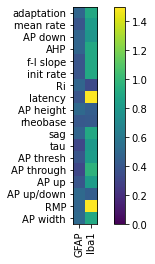

In [19]:

fig, ax = plt.subplots()

im=ax.imshow(all_p_val[:,[0,2]],vmin=0, vmax=1.5)
fig.colorbar(im,orientation="vertical")

labels_y = ['adaptation','mean rate','AP down','AHP','f-I slope','init rate','Ri', 'latency', 'AP height','rheobase','sag',
           'tau','AP thresh', 'AP through', 'AP up','AP up/down','RMP','AP width']

labels_x = ['GFAP', 'Iba1']

# set the ticks number
plt.xticks(np.arange(0, 2, 1.0))
plt.yticks(np.arange(0, 18, 1.0))

ax.set_xticklabels(labels_x,rotation='vertical')
ax.set_yticklabels(labels_y,rotation='horizontal')
# save figure
#plt.savefig('p_values_table.pdf',format='pdf')
print('Significance level -log10(alpha): ' + str(-np.log10(0.05)))


# Ephys features comparisons

## Voltage sag

/home/tom/anaconda2/envs/hivscc/lib/python3.7/site-packages/seaborn/categorical.py:2775: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


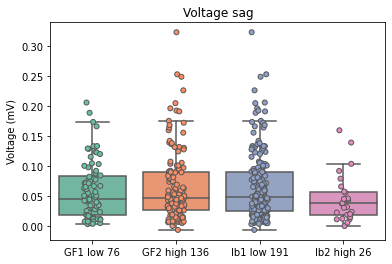

In [20]:

# GFAP
spiny_norm_cell_ids, spiny_path_cell_ids = provide_cell_ids(path_info,my_data_MET_ephys,'GFAP Cortex',1,1)
f1=ephys_human.loc[ephys_human['specimen_id'].isin(spiny_norm_cell_ids)]['sag'].values
f2=ephys_human.loc[ephys_human['specimen_id'].isin(spiny_path_cell_ids)]['sag'].values
l1='GF1 low' +' ' +str(len(spiny_norm_cell_ids))
l2='GF2 high' +' ' +str(len(spiny_path_cell_ids))

# IBA1
spiny_norm_cell_ids, spiny_path_cell_ids = provide_cell_ids(path_info,my_data_MET_ephys,'Iba1 Cortex',1,1)
f3=ephys_human.loc[ephys_human['specimen_id'].isin(spiny_norm_cell_ids)]['sag'].values
f4=ephys_human.loc[ephys_human['specimen_id'].isin(spiny_path_cell_ids)]['sag'].values
l3='Ib1 low' +' ' +str(len(spiny_norm_cell_ids))
l4='Ib2 high' + ' ' +str(len(spiny_path_cell_ids))

# Ki67
spiny_norm_cell_ids, spiny_path_cell_ids = provide_cell_ids(path_info,my_data_MET_ephys,'Ki67',1,1)
f5=ephys_human.loc[ephys_human['specimen_id'].isin(spiny_norm_cell_ids)]['sag'].values
f6=ephys_human.loc[ephys_human['specimen_id'].isin(spiny_path_cell_ids)]['sag'].values
l5='Ki1 low' +' ' +str(len(spiny_norm_cell_ids))
l6='Ki2 high' + ' ' +str(len(spiny_path_cell_ids))

# Cellularity
spiny_norm_cell_ids, spiny_path_cell_ids = provide_cell_ids(path_info,my_data_MET_ephys,'Cellularity',1,1)
f7=ephys_human.loc[ephys_human['specimen_id'].isin(spiny_norm_cell_ids)]['sag'].values
f8=ephys_human.loc[ephys_human['specimen_id'].isin(spiny_path_cell_ids)]['sag'].values
l7='Cel1 low' +' ' +str(len(spiny_norm_cell_ids))
l8='Cel2 high' + ' ' +str(len(spiny_path_cell_ids))

# save part
box_stripe_plot_2(f1,f2,f3,f4,l1,l2,l3,l4,'Voltage sag','Voltage (mV)')
#plt.savefig('voltage_sag.pdf',format='pdf')



## Iba1

/home/tom/anaconda2/envs/hivscc/lib/python3.7/site-packages/seaborn/categorical.py:2775: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


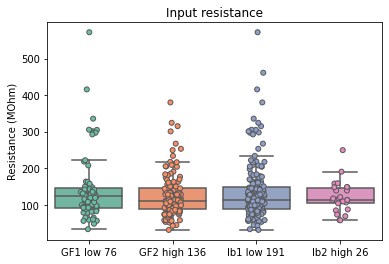

In [21]:

# GFAP
spiny_norm_cell_ids, spiny_path_cell_ids = provide_cell_ids(path_info,my_data_MET_ephys,'GFAP Cortex',1,1)
f1=ephys_human.loc[ephys_human['specimen_id'].isin(spiny_norm_cell_ids)]['input_resistance'].values
f2=ephys_human.loc[ephys_human['specimen_id'].isin(spiny_path_cell_ids)]['input_resistance'].values
l1='GF1 low'  + ' ' +str(len(spiny_norm_cell_ids))
l2='GF2 high' + ' ' +str(len(spiny_path_cell_ids))

# IBA1
spiny_norm_cell_ids, spiny_path_cell_ids = provide_cell_ids(path_info,my_data_MET_ephys,'Iba1 Cortex',1,1)
f3=ephys_human.loc[ephys_human['specimen_id'].isin(spiny_norm_cell_ids)]['input_resistance'].values
f4=ephys_human.loc[ephys_human['specimen_id'].isin(spiny_path_cell_ids)]['input_resistance'].values
l3='Ib1 low' + ' ' +str(len(spiny_norm_cell_ids))
l4='Ib2 high' + ' ' +str(len(spiny_path_cell_ids))

# Ki67
spiny_norm_cell_ids, spiny_path_cell_ids = provide_cell_ids(path_info,my_data_MET_ephys,'Ki67',1,1)
f5=ephys_human.loc[ephys_human['specimen_id'].isin(spiny_norm_cell_ids)]['input_resistance'].values
f6=ephys_human.loc[ephys_human['specimen_id'].isin(spiny_path_cell_ids)]['input_resistance'].values
l5='Ki1 low' + ' ' +str(len(spiny_norm_cell_ids))
l6='Ki2 high' + ' ' +str(len(spiny_path_cell_ids))

# Cellularity
spiny_norm_cell_ids, spiny_path_cell_ids = provide_cell_ids(path_info,my_data_MET_ephys,'Cellularity',1,1)
f7=ephys_human.loc[ephys_human['specimen_id'].isin(spiny_norm_cell_ids)]['input_resistance'].values
f8=ephys_human.loc[ephys_human['specimen_id'].isin(spiny_path_cell_ids)]['input_resistance'].values
l7='Cel1 low' + ' ' +str(len(spiny_norm_cell_ids))
l8='Cel2 high'+ ' ' +str(len(spiny_path_cell_ids))

# save part
box_stripe_plot_2(f1,f2,f3,f4,l1,l2,l3,l4,'Input resistance','Resistance (MOhm)')
#plt.savefig('input_resistance.pdf',format='pdf')



## Voltage baseline

/home/tom/anaconda2/envs/hivscc/lib/python3.7/site-packages/seaborn/categorical.py:2775: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


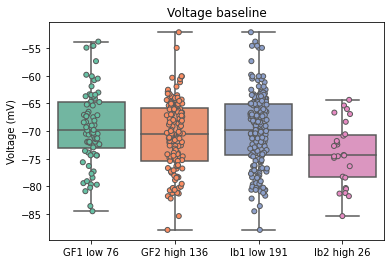

In [22]:

# GFAP
spiny_norm_cell_ids, spiny_path_cell_ids = provide_cell_ids(path_info,my_data_MET_ephys,'GFAP Cortex',1,1)
f1=ephys_human.loc[ephys_human['specimen_id'].isin(spiny_norm_cell_ids)]['v_baseline'].values
f2=ephys_human.loc[ephys_human['specimen_id'].isin(spiny_path_cell_ids)]['v_baseline'].values
l1='GF1 low'  + ' ' +str(len(spiny_norm_cell_ids))
l2='GF2 high'  + ' ' +str(len(spiny_path_cell_ids))

# IBA1
spiny_norm_cell_ids, spiny_path_cell_ids = provide_cell_ids(path_info,my_data_MET_ephys,'Iba1 Cortex',1,1)
f3=ephys_human.loc[ephys_human['specimen_id'].isin(spiny_norm_cell_ids)]['v_baseline'].values
f4=ephys_human.loc[ephys_human['specimen_id'].isin(spiny_path_cell_ids)]['v_baseline'].values
l3='Ib1 low'  + ' ' +str(len(spiny_norm_cell_ids))
l4='Ib2 high'  + ' ' +str(len(spiny_path_cell_ids))

# Ki67
spiny_norm_cell_ids, spiny_path_cell_ids = provide_cell_ids(path_info,my_data_MET_ephys,'Ki67',1,1)
f5=ephys_human.loc[ephys_human['specimen_id'].isin(spiny_norm_cell_ids)]['v_baseline'].values
f6=ephys_human.loc[ephys_human['specimen_id'].isin(spiny_path_cell_ids)]['v_baseline'].values
l5='Ki1 low'  + ' ' +str(len(spiny_norm_cell_ids))
l6='Ki2 high'  + ' ' +str(len(spiny_path_cell_ids))

# Cellularity
spiny_norm_cell_ids, spiny_path_cell_ids = provide_cell_ids(path_info,my_data_MET_ephys,'Cellularity',1,1)
f7=ephys_human.loc[ephys_human['specimen_id'].isin(spiny_norm_cell_ids)]['v_baseline'].values
f8=ephys_human.loc[ephys_human['specimen_id'].isin(spiny_path_cell_ids)]['v_baseline'].values
l7='Cel1 low'  + ' ' +str(len(spiny_norm_cell_ids))
l8='Cel2 high'  + ' ' +str(len(spiny_path_cell_ids))

# save part
box_stripe_plot_2(f1,f2,f3,f4,l1,l2,l3,l4,'Voltage baseline','Voltage (mV)')
#plt.savefig('voltage_base.pdf',format='pdf')


## Membrane time constant

/home/tom/anaconda2/envs/hivscc/lib/python3.7/site-packages/seaborn/categorical.py:2775: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


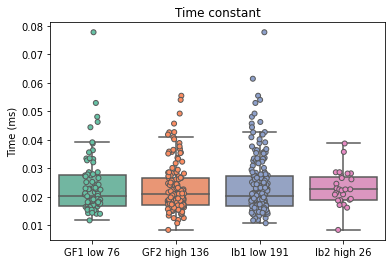

In [23]:

# GFAP
spiny_norm_cell_ids, spiny_path_cell_ids = provide_cell_ids(path_info,my_data_MET_ephys,'GFAP Cortex',1,1)
f1=ephys_human.loc[ephys_human['specimen_id'].isin(spiny_norm_cell_ids)]['tau'].values
f2=ephys_human.loc[ephys_human['specimen_id'].isin(spiny_path_cell_ids)]['tau'].values
l1='GF1 low'  + ' ' +str(len(spiny_norm_cell_ids))
l2='GF2 high'  + ' ' +str(len(spiny_path_cell_ids))

# IBA1
spiny_norm_cell_ids, spiny_path_cell_ids = provide_cell_ids(path_info,my_data_MET_ephys,'Iba1 Cortex',1,1)
f3=ephys_human.loc[ephys_human['specimen_id'].isin(spiny_norm_cell_ids)]['tau'].values
f4=ephys_human.loc[ephys_human['specimen_id'].isin(spiny_path_cell_ids)]['tau'].values
l3='Ib1 low' + ' ' +str(len(spiny_norm_cell_ids))
l4='Ib2 high'  + ' ' +str(len(spiny_path_cell_ids))

# Ki67
spiny_norm_cell_ids, spiny_path_cell_ids = provide_cell_ids(path_info,my_data_MET_ephys,'Ki67',1,1)
f5=ephys_human.loc[ephys_human['specimen_id'].isin(spiny_norm_cell_ids)]['tau'].values
f6=ephys_human.loc[ephys_human['specimen_id'].isin(spiny_path_cell_ids)]['tau'].values
l5='Ki1 low' + ' ' +str(len(spiny_norm_cell_ids))
l6='Ki2 high' + ' ' +str(len(spiny_path_cell_ids))

# Cellularity
spiny_norm_cell_ids, spiny_path_cell_ids = provide_cell_ids(path_info,my_data_MET_ephys,'Cellularity',1,1)
f7=ephys_human.loc[ephys_human['specimen_id'].isin(spiny_norm_cell_ids)]['tau'].values
f8=ephys_human.loc[ephys_human['specimen_id'].isin(spiny_path_cell_ids)]['tau'].values
l7='Cel1 low'+ ' ' +str(len(spiny_norm_cell_ids))
l8='Cel2 high'+ ' ' +str(len(spiny_path_cell_ids))

# save part
box_stripe_plot_2(f1,f2,f3,f4,l1,l2,l3,l4,'Time constant','Time (ms)')
#plt.savefig('tau.pdf',format='pdf')
